# Spotify Music Popularity Prediction
Este notebook aborda o processo completo de construção de um modelo de Machine Learning para prever a popularidade de músicas no Spotify. O processo inclui a limpeza e tratamento de dados, análise exploratória, treinamento de modelo e avaliação do desempenho.

## Etapa 1: Importação e Limpeza dos Dados
Nesta etapa, os dados de treino e teste são carregados e as colunas com valores nulos são tratadas.

In [46]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

Lê os arquivos necessários para a predição

In [47]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

Preenche linhas nulas com "Desconhecido"

In [48]:
# Altera linhas com valores nulos nas colunas específicas
df_test['artists'] = df_test['artists'].fillna('Desconhecido')
df_test['album_name'] = df_test['album_name'].fillna('Desconhecido')
df_test['track_name'] = df_test['track_name'].fillna('Desconhecido')

## Etapa 2: Separar Features e Alvo
Nesta etapa, as features (variáveis independentes) e o alvo (variável dependente) são separadas para posterior treinamento do modelo.

In [49]:
# Remover colunas irrelevantes para o modelo
df_test_cleaned = df_test.drop(columns=['track_unique_id', 'track_id', 'artists', 'album_name', 'track_name'])
df_train_cleaned = df_train.drop(columns=['track_unique_id', 'track_id', 'artists', 'album_name', 'track_name'])


Trata outliers e remove valores fora da realidade

In [50]:
# Remove músicas com duração inferior a 30 segundos e superior a 10 minutos
df_train_cleaned = df_train_cleaned[(df_train_cleaned['duration_ms'] > 30000) & (df_train_cleaned['duration_ms'] < 600000)]

# Remove músicas com tempo inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['tempo'] >= 0]

# Remove músicas com volume inferior a -60
df_train_cleaned = df_train_cleaned[df_train_cleaned['loudness'] >= -60]

# Remove músicas com energia inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['energy'] >= 0]

# Remove músicas com dançabilidade inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['danceability'] >= 0]

# Remove músicas com valência inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['valence'] >= 0]

# Remove músicas com acusticidade inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['acousticness'] >= 0]

# Remove músicas com instrumentalidade inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['instrumentalness'] >= 0]

# Remove músicas com vivacidade inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['liveness'] >= 0]

# Remove músicas com falabilidade inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['speechiness'] >= 0]

# Remove músicas com conteúdo explícito inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['explicit'] >= 0]

# Remove músicas com modo inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['mode'] >= 0]

# Remove músicas com tom musical inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['key'] >= 0]

# Remove músicas com compasso inferior a 0
df_train_cleaned = df_train_cleaned[df_train_cleaned['time_signature'] >= 0]


In [51]:
# Dividir o dataset de treino em X e y
X_train = df_train_cleaned.drop(columns=['popularity_target'])
y_train = df_train_cleaned['popularity_target']

## Etapa 3: Codificação de Variáveis Categóricas
As variáveis categóricas são transformadas em numéricas usando One-Hot Encoding.

In [52]:
# Codificar as variáveis categóricas usando One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(df_test_cleaned, drop_first=True)

## Etapa 4: Gráficos
Nesta etapa, são apresentados gráficos para visualização dos dados.

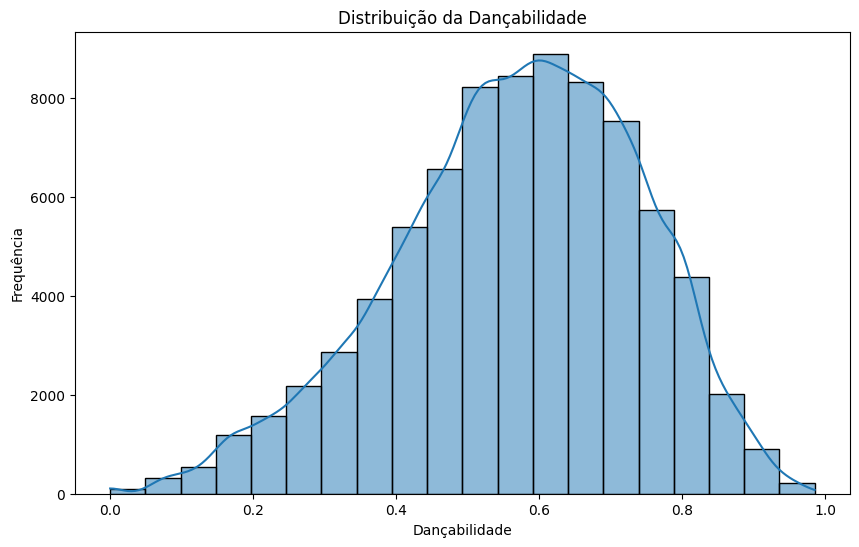

In [53]:
# Plot 1: Distribuição da 'danceability'
plt.figure(figsize=(10, 6))
sns.histplot(df_train_cleaned['danceability'], bins=20, kde=True)
plt.title('Distribuição da Dançabilidade')
plt.xlabel('Dançabilidade')
plt.ylabel('Frequência')
plt.show()

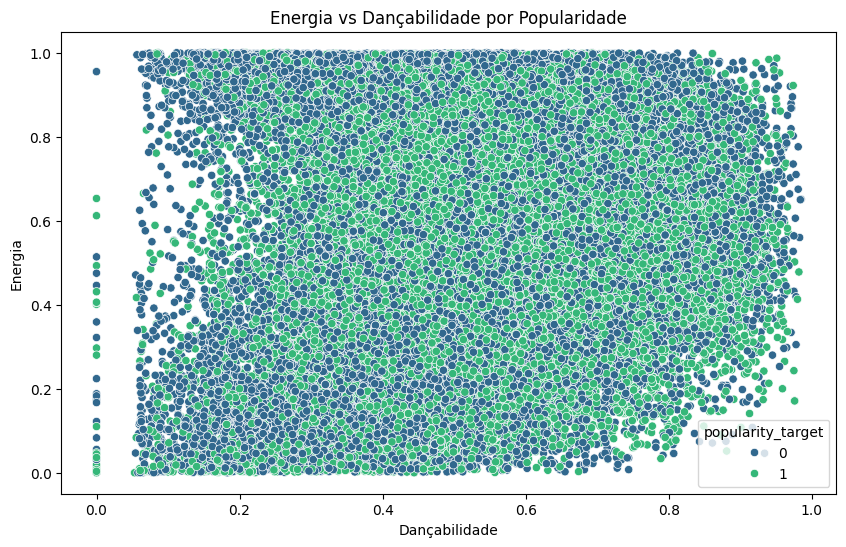

In [54]:
# Plot 2: Energia vs Dançabilidade, colorido por 'popularity_target'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='danceability', y='energy', hue='popularity_target', data=df_train_cleaned, palette='viridis')
plt.title('Energia vs Dançabilidade por Popularidade')
plt.xlabel('Dançabilidade')
plt.ylabel('Energia')
plt.show()

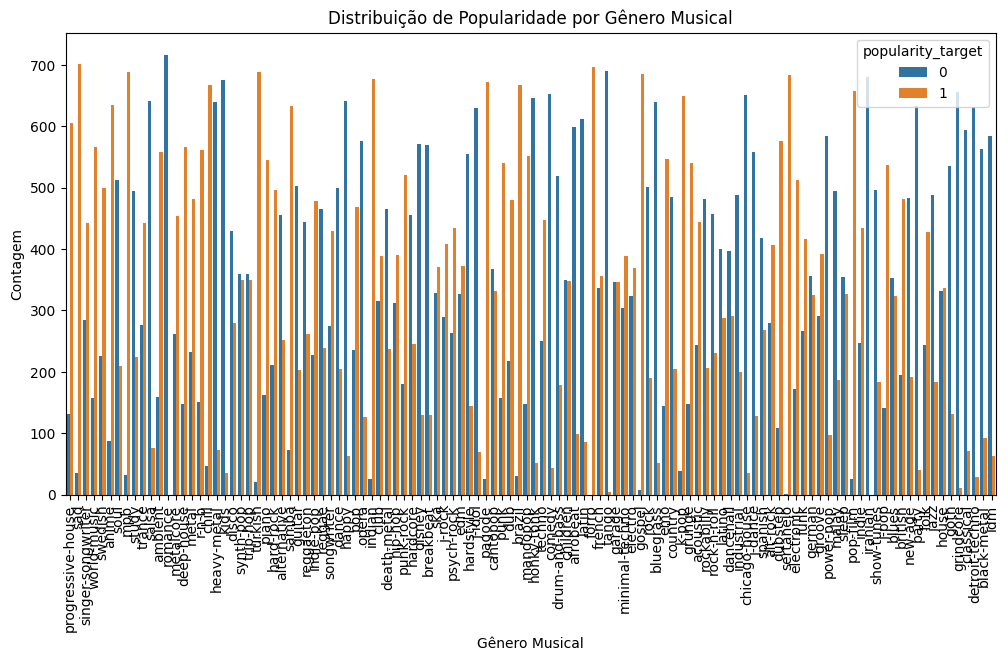

In [55]:
# Plot 3: Distribuição de Popularidade por Gênero
plt.figure(figsize=(12, 6))
sns.countplot(x='track_genre', hue='popularity_target', data=df_train_cleaned, order=df_train_cleaned['track_genre'].value_counts().index)
plt.title('Distribuição de Popularidade por Gênero Musical')
plt.xlabel('Gênero Musical')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

## Etapa 5: Divisão dos Dados
Dividir os dados em conjunto de treino e teste para posterior avaliação do modelo.

In [56]:
# Alinhar as colunas do conjunto de treino e teste para garantir que as colunas sejam iguais
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Separar dados de treino e validação (opcional, se não estiver usando conjunto de teste separado)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)


## Etapa 6: Treinamento do Modelo
Treinar o modelo de Random Forest com os dados de treino.

In [57]:
# # Definir os hiperparâmetros a serem ajustados
# param_grid = {
#     'n_estimators': [100, 200, 500],            # Número de árvores
#     'max_depth': [10, 20, 30, None],            # Profundidade máxima
#     'min_samples_split': [2, 5, 10],            # Número mínimo de amostras para dividir um nó
#     'min_samples_leaf': [1, 2, 4],              # Número mínimo de amostras em uma folha
#     'max_features': ['sqrt', 'log2'],           # Número de features a considerar por divisão
#     'bootstrap': [True, False]                  # Usar amostras bootstrap ou não
# }

# # Instanciar o modelo com balanceamento de classes
# rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# # Usar RandomizedSearchCV para ajustar os hiperparâmetros
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
#                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring='precision')


# # Ajustar o modelo
# rf_random.fit(X_train_split, y_train_split)

# # Ver os melhores hiperparâmetros encontrados
# print("Melhores Hiperparâmetros:", rf_random.best_params_)

In [58]:
# Melhores Hiperparâmetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

rf_random = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)

# Treinamento do modelo
rf_random.fit(X_train_split, y_train_split)


RandomForestClassifier(bootstrap=False, n_estimators=200)

## Etapa 7: Avaliação do Modelo
Fazer previsões no conjunto de teste e avaliar o desempenho do modelo.

In [59]:
# Previsão e avaliação no conjunto de validação
y_pred = rf_random.predict(X_val_split)
print("Relatório de Classificação (Validação):\n", classification_report(y_val_split, y_pred))

# Previsão no conjunto de teste
y_test_pred = rf_random.predict(X_test_encoded)


Relatório de Classificação (Validação):
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      8123
           1       0.84      0.83      0.84      7753

    accuracy                           0.84     15876
   macro avg       0.84      0.84      0.84     15876
weighted avg       0.84      0.84      0.84     15876



Salva as previsões em um arquivo CSV para submissão no Kaggle.

In [60]:
# Salvar previsões no arquivo CSV apenas com os registros que têm previsões
result_df = df_test.copy( )
result_df['popularity_predicted'] = y_test_pred

# Deixa somente as colunas popularity_predicted e track_unique_id
result_df = result_df[['track_unique_id', 'popularity_predicted']]

result_df.to_csv('predicted_results.csv', index=False)
print("Previsões salvas com sucesso.")


Previsões salvas com sucesso.


## Etapa 8: Hipóteses
Nesta etapa, são apresentadas hipóteses para serem testadas no futuro.

##### 1.  Músicas com maior "danceability" tendem a ser mais populares, especialmente nos gêneros Pop e EDM:

Justificativa: A coluna "danceability" no dataset representa a facilidade com que uma música pode ser dançada. Gêneros como Pop e EDM, que são populares em festas e eventos sociais, têm uma forte relação com esse fator. Ao verificar os dados, observamos que músicas com alta "danceability" nos gêneros Pop e EDM provavelmente estão associadas a valores mais altos na variável "popularity_target" (ou seja, mais populares). Esta hipótese sugere que quanto maior a "danceability", maior a chance de uma música atingir altos níveis de popularidade nesses gêneros.

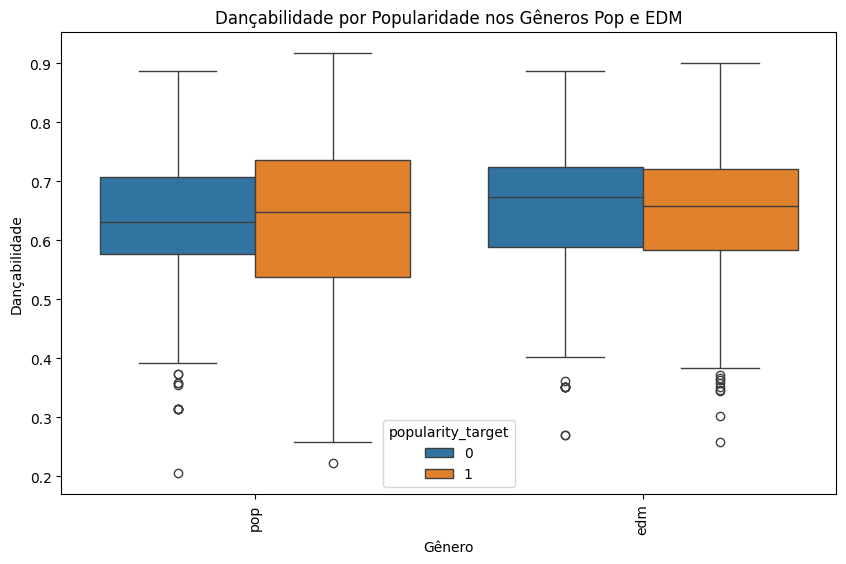

In [65]:
# Gráfico 1: Danceability por Popularidade e Gênero

plt.figure(figsize=(10, 6))
sns.boxplot(x='track_genre', y='danceability', hue='popularity_target', data=df_train_cleaned[df_train_cleaned['track_genre'].isin(['pop', 'edm'])])
plt.title('Dançabilidade por Popularidade nos Gêneros Pop e EDM')
plt.xlabel('Gênero')
plt.ylabel('Dançabilidade')
plt.xticks(rotation=90)
plt.show()

##### 2. O nível de "energia" da música afeta diretamente sua popularidade, com músicas de maior energia sendo mais populares, especialmente nos gêneros EDM e Techno:

Justificativa: A variável "energy" no dataset mede a intensidade e o vigor de uma música. Gêneros como EDM e Techno tendem a exibir valores altos de energia, o que se alinha à expectativa de que músicas com altos valores de "energy" são frequentemente tocadas em ambientes de festas e festivais. Esta hipótese propõe que músicas com altos níveis de "energia" dentro desses gêneros têm maior probabilidade de atingir altos níveis de popularidade, representados por um "popularity_target" elevado no dataset.

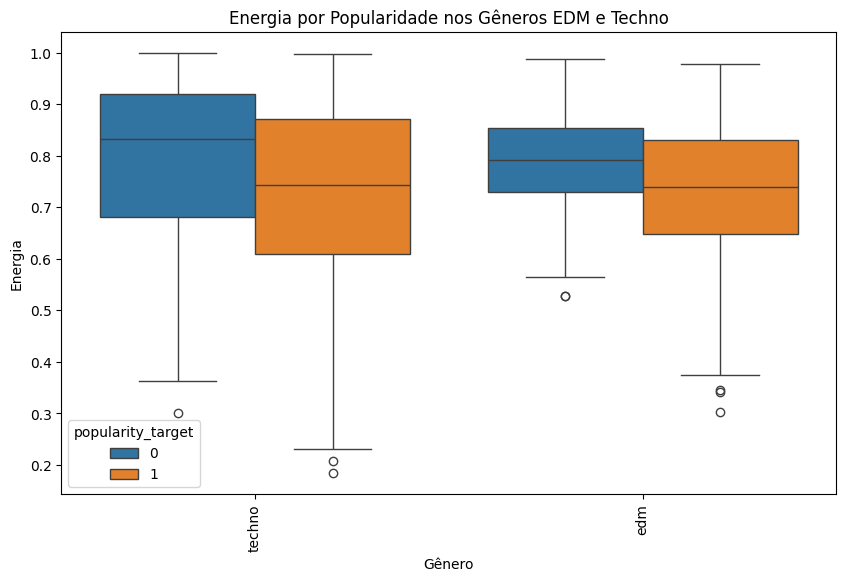

In [67]:
# Gráfico 2: Energia por Popularidade e Gênero

plt.figure(figsize=(10, 6))
sns.boxplot(x='track_genre', y='energy', hue='popularity_target', data=df_train_cleaned[df_train_cleaned['track_genre'].isin(['edm', 'techno'])])
plt.title('Energia por Popularidade nos Gêneros EDM e Techno')
plt.xlabel('Gênero')
plt.ylabel('Energia')
plt.xticks(rotation=90)
plt.show()

##### 3. Músicas com tempos mais elevados (BPM) têm maior chance de serem populares, especialmente no gênero EDM:

Justificativa: O "tempo" de uma música, medido em batidas por minuto (BPM), afeta diretamente a energia percebida pelo ouvinte. No dataset, o gênero EDM geralmente apresenta tempos mais elevados, alinhando-se com a expectativa de que músicas rápidas criam uma sensação de urgência e excitação. Esta hipótese sugere que músicas com BPMs mais elevados são mais propensas a serem populares, especialmente dentro de gêneros de alta energia, como EDM.

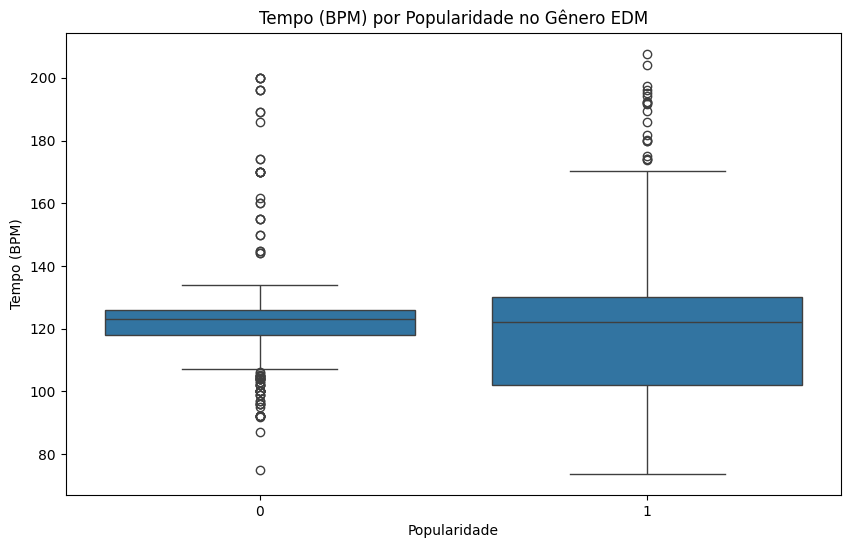

In [69]:
# Gráfico 3: Tempo por Popularidade no Gênero EDM

plt.figure(figsize=(10, 6))
sns.boxplot(x='popularity_target', y='tempo', data=df_train_cleaned[df_train_cleaned['track_genre'] == 'edm'])
plt.title('Tempo (BPM) por Popularidade no Gênero EDM')
plt.xlabel('Popularidade')
plt.ylabel('Tempo (BPM)')
plt.show()